# Imports

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import json
import pandas as pd
from sklearn.metrics import mean_squared_error

In [2]:
import math

def distCalc(pt1, pt2):
    dis = math.sqrt((pt2[0]-pt1[0])**2 + (pt2[1]-pt1[1])**2)
    return dis

def calc_dist_from_4m(fencer):
    # Negative if to the left of engarde, positive otherwise
    if (fencer[0] < pisteLines['leftEngardeLine'][0]):
        # Left side
        distFromLeftEGLine = leftEngardeToLeftWarning * (fencer[0] - pisteLines['leftEngardeLine'][0])
        return distFromLeftEGLine - 200
    elif (fencer[0] < pisteLines['middleLines'][0]):
        distFromMidLine = leftEnGardeToMid * (fencer[0] - pisteLines['middleLines'][0])
        return distFromMidLine
    elif (fencer[0] < pisteLines['rightEngardeLine'][0]):
        distFromMidLine = rightEnGardeToMid * (fencer[0] - pisteLines['middleLines'][0])
        return distFromMidLine
    else:
        distFromRightEGLine = rightEngardeToRightWarning * (fencer[0] - pisteLines['rightEngardeLine'][0])
        return 200 + distFromRightEGLine

# Get momentum graph time and alphapose data

In [3]:
# Navigate to alphapose data
os.chdir('./wzvskor')
is_epee = False
is_foil = False
fps = 29.97
results = pd.read_csv('./momentum_results.csv', header=None)
ground_truth = pd.read_csv('./groundtruth.csv')
ground_truth.fillna(0, inplace=True)
os.chdir('./output')
left_df = pd.read_csv('./left_momentum_results.csv', header=None)
left_fencer = left_df.to_records(index=False).tolist()

right_df = pd.read_csv('./right_momentum_results.csv', header=None)
right_fencer = right_df.to_records(index=False).tolist()
pisteLines_df = pd.read_csv('./pisteLines.csv')
pisteLines = {}
pisteLines['middleLines'] = (pisteLines_df['middleLines'][0], pisteLines_df['middleLines'][1])
pisteLines['leftEngardeLine'] = (pisteLines_df['leftEngardeLine'][0], pisteLines_df['leftEngardeLine'][1])
pisteLines['rightEngardeLine'] = (pisteLines_df['rightEngardeLine'][0], pisteLines_df['rightEngardeLine'][1])
pisteLines['leftWarningLine'] = (pisteLines_df['leftWarningLine'][0], pisteLines_df['leftWarningLine'][1])
pisteLines['rightWarningLine'] = (pisteLines_df['rightWarningLine'][0], pisteLines_df['rightWarningLine'][1])
leftEnGardeToMid = 200 / distCalc(pisteLines['middleLines'], pisteLines['leftEngardeLine'])
rightEnGardeToMid = 200 / distCalc(pisteLines['middleLines'], pisteLines['rightEngardeLine'])
leftEngardeToLeftWarning = 300 / distCalc(pisteLines['leftEngardeLine'], pisteLines['leftWarningLine'])
rightEngardeToRightWarning = 300 / distCalc(pisteLines['rightEngardeLine'], pisteLines['rightWarningLine'])

left_dist = []
for coord in left_fencer:
    left_dist.append(calc_dist_from_4m(coord))
    
right_dist = []
for coord in right_fencer:
    right_dist.append(calc_dist_from_4m(coord))
    
dist_bw_fencers = []
for i in range(len(left_dist)):
    dist_bw_fencers.append(((right_dist[i] + 700) - (left_dist[i] + 700)))

vel_left = []
for i in range(len(left_dist) - 1):
    vel_left.append((left_dist[i + 1] - left_dist[i]))
    
vel_right = []
for i in range(len(right_dist) - 1):
    vel_right.append((right_dist[i + 1] - right_dist[i]))
    
os.chdir('../..')

In [4]:
## For epee if both score points, may also help to solve accidental scoring
last_time = results[0][0]
last_momentum = results[1][0]

results_time = [last_time]
results_momentum = [last_momentum]

for i in range(1, len(results[0])):
    time = results[0][i]
    momentum = results[1][i]
    
    if is_epee and (time - last_time) < 5.0:
        # Score should be for both sides
        results_momentum[-1] = momentum
        continue
    elif is_epee and (min(dist_bw_fencers[int(last_time*30) : int(time*30)]) > 400):
        results_momentum[-1] = momentum
    else:
        results_time.append(time)
        results_momentum.append(momentum)
    last_time = time
    last_momentum = momentum
    
results_time_by_frame = [i * 30 for i in results_time]

## Get ground truth data

In [5]:
## Current method does not detect when referee stops the bout
keep = False
gt_timings = []
gt_loc = []
gt_start = []
for index, row in ground_truth.iterrows():
    if row['Bout Start & End'] == "Action":
        if row['Actions Location'] == 0:
            keep = False
        else:
            gt_start.append(row['Position'] / 1000)
            gt_loc.append(row['Actions Location'])
            keep = True
    if row['Bout Start & End'] == "Pause":
        if keep:
            gt_timings.append(row['Position'] / 1000)
            
gt_timings = [(i * fps) / 30 for i in gt_timings]
gt_start = [(i * fps) / 30 for i in gt_start]

In [6]:
start = int(results_time_by_frame[0])
end = int(results_time_by_frame[1])
frames = [i for i in range(start, end)]

Text(0.5, 1.0, 'Right Velocity')

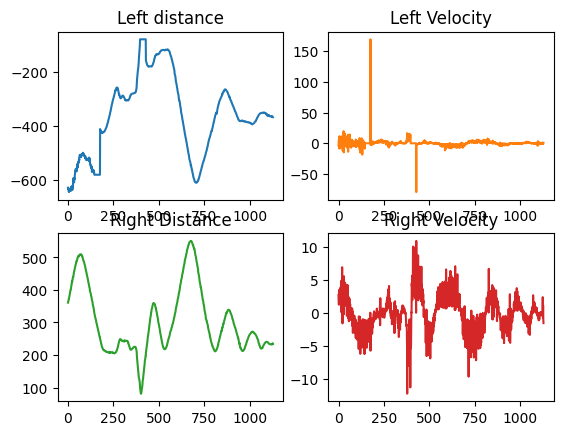

In [7]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(frames, left_dist[:end])
axs[0, 0].set_title('Left distance')
axs[0, 1].plot(frames, vel_left[:end], 'tab:orange')
axs[0, 1].set_title('Left Velocity')
axs[1, 0].plot(frames, right_dist[:end], 'tab:green')
axs[1, 0].set_title('Right Distance')
axs[1, 1].plot(frames, vel_right[:end], 'tab:red')
axs[1, 1].set_title('Right Velocity')

## Create a loop to run through all the timings and find point of action

In [8]:
## Left fencer score, -200 -> L, -200 - 200 -> M, > 200 -> R
def score_location(dist_chart, time):
    score_dist = dist_chart[time]
    if (score_dist < -200):
        return "SELF_Side"
    elif (-200 <= score_dist and score_dist <= 200):
        return "MID_Side"
    else:
        return "OPP_Side"
    
def did_left_score(prev_momentum, curr_momentum):
    # Momentum calculated by Left - Right
    return (prev_momentum < curr_momentum)

def did_right_score(prev_momentum, curr_momentum):
    # Momentum calculated by Left - Right
    return (prev_momentum > curr_momentum)

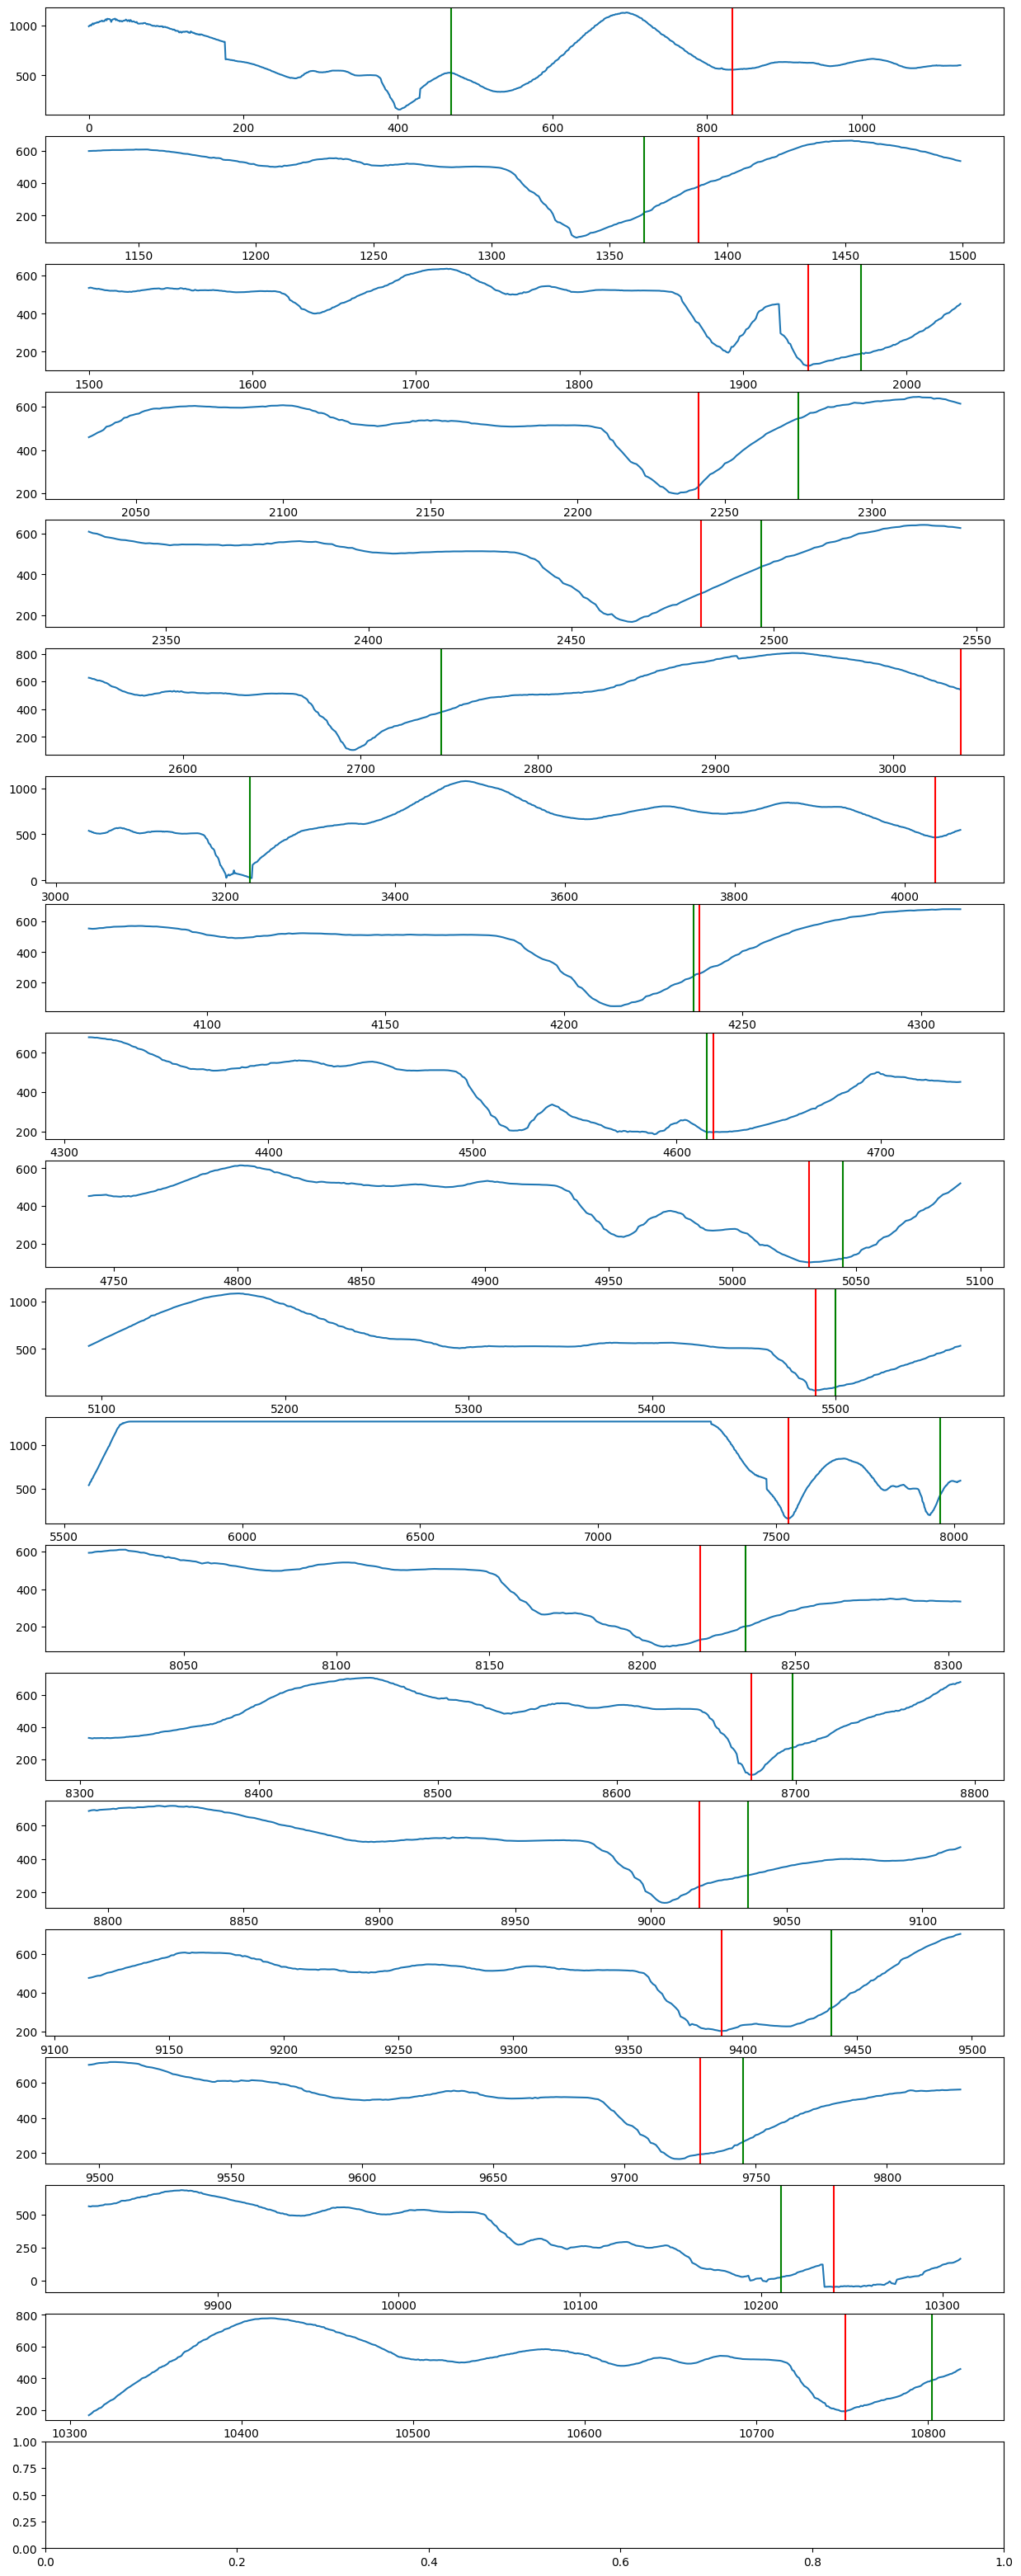

In [9]:
minpts = []
fig, axs = plt.subplots(len(results_time_by_frame), figsize=(15,40), sharex=False)
for index in range(1, len(results_time_by_frame)):
    start = int(results_time_by_frame[index - 1])
    end = int(results_time_by_frame[index])
    diff = (end - start)
    last_30 = start + int(diff * 0.7)
    
    hit_time = dist_bw_fencers.index(min(dist_bw_fencers[last_30:end]))
    frames = [i for i in range(start, end)]
    axs[index - 1].plot(frames, dist_bw_fencers[start:end])
    axs[index - 1].axvline(x = hit_time, color = 'r')
    axs[index - 1].axvline(x = gt_timings[index - 1] * 30, color = 'g')
    
    if (did_left_score(results_momentum[index - 1], results_momentum[index])):
        score_loc = score_location(left_dist, hit_time)
        scorer = "Point_Self"
    elif (did_right_score(results_momentum[index - 1], results_momentum[index])):
        score_loc = score_location(right_dist, hit_time)
        scorer = "Point_Opp"
    else:
        score_loc = score_location(right_dist, hit_time)
        scorer = "Simult"
    minpts.append((hit_time, score_loc, scorer))

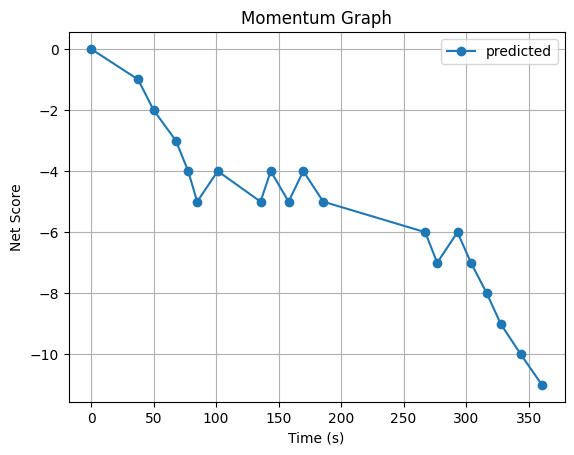

In [10]:
plt.title("Momentum Graph")
plt.xlabel("Time (s)")
plt.ylabel("Net Score")
plt.grid()
plt.plot(results_time, results_momentum, marker='o', label='predicted')
plt.legend()

In [11]:
minpts

[(833, 'OPP_Side', 'Point_Opp'),
 (1388, 'OPP_Side', 'Point_Opp'),
 (1940, 'SELF_Side', 'Point_Opp'),
 (2241, 'MID_Side', 'Point_Opp'),
 (2482, 'MID_Side', 'Point_Opp'),
 (3038, 'SELF_Side', 'Point_Self'),
 (4036, 'OPP_Side', 'Point_Opp'),
 (4238, 'MID_Side', 'Point_Self'),
 (4618, 'SELF_Side', 'Point_Opp'),
 (5031, 'MID_Side', 'Point_Self'),
 (5489, 'MID_Side', 'Point_Opp'),
 (7535, 'MID_Side', 'Point_Opp'),
 (8219, 'OPP_Side', 'Point_Opp'),
 (8675, 'MID_Side', 'Point_Self'),
 (9018, 'MID_Side', 'Point_Opp'),
 (9391, 'MID_Side', 'Point_Opp'),
 (9729, 'MID_Side', 'Point_Opp'),
 (10240, 'OPP_Side', 'Point_Opp'),
 (10752, 'MID_Side', 'Point_Opp')]

In [12]:
hit_timings = [i[0] / 30 for i in minpts]

## Compare groundtruth

In [13]:
data_pts = len(hit_timings) - len(gt_timings)
mse = mean_squared_error(hit_timings, gt_timings)
rmse = mean_squared_error(hit_timings, gt_timings, squared=False)
print("Difference in data points:", data_pts)
print("MSE: ", mse)
print("RMSE: ", rmse)

Difference in data points: 0
MSE:  62.04876851145358
RMSE:  7.877104068847483


## Find patterns in start

In [14]:
## Functions to determine if fencers are at engardeline

def left_at_engarde(dist):
    return (dist < -170) and (dist > -280)

def right_at_engarde(dist):
    return (dist > 170) and (dist < 280)

def fencer_stationary(vel):
    return (vel > -7) and (vel < 7)

def both_fencers_engarde_FE(dist_bw_fencers, left_vel, right_vel):
    return (dist_bw_fencers > 340) and (dist_bw_fencers < 480) and fencer_stationary(left_vel) and fencer_stationary(right_vel)

def both_fencers_engarde(left_dist, right_dist, left_vel, right_vel):
    return left_at_engarde(left_dist) and right_at_engarde(right_dist) and fencer_stationary(left_vel) and fencer_stationary(right_vel)

def check_for_start(left_dist_arr, right_dist_arr, left_vel_arr, right_vel_arr, start, end):
    fencers_engarded = False
    for index in range(start, end):
        left_dist = left_dist_arr[index]
        right_dist = right_dist_arr[index]
        left_vel = left_vel_arr[index]
        right_vel = right_vel_arr[index]
        if not fencers_engarded:
            fencers_engarded = both_fencers_engarde(left_dist, right_dist, left_vel, right_vel)
        else:
            ## Fencers have engarded already, check if they move out towards one another
            if not both_fencers_engarde(left_dist, right_dist, left_vel, right_vel) and left_vel > 0 and right_vel < 0 and dist_bw_fencers[index] < 430:
                return index
    
    return end

def check_for_all_start(left_dist_arr, right_dist_arr, left_vel_arr, right_vel_arr, start, end):
    fencers_engarded = False
    curr_end = end
    engarde_count = 0
    last_found = 0
    for index in range(start, end):
        left_dist = left_dist_arr[index]
        right_dist = right_dist_arr[index]
        left_vel = left_vel_arr[index]
        right_vel = right_vel_arr[index]
        if not fencers_engarded:
            if both_fencers_engarde(left_dist, right_dist, left_vel, right_vel):
                engarde_count += 1
                last_found = index
            elif (index - last_found > 5):
                engarde_count = 0
            if engarde_count == 5:
                fencers_engarded = True
        else:
            ## Fencers have engarded already, check if they move out towards one another
            if not both_fencers_engarde(left_dist, right_dist, left_vel, right_vel) and left_vel > 0 and right_vel < 0 and dist_bw_fencers[index] < 410:
                curr_end = index
                fencers_engarded = False
                engarde_count = 0
    
    return curr_end

def check_for_all_start_FE(left_dist_arr, right_dist_arr, left_vel_arr, right_vel_arr, start, end):
    fencers_engarded = False
    curr_end = end
    engarde_count = 0
    last_found = 0
    for index in range(start, end):
        left_dist = left_dist_arr[index]
        right_dist = right_dist_arr[index]
        left_vel = left_vel_arr[index]
        right_vel = right_vel_arr[index]
        if not fencers_engarded:
            if both_fencers_engarde_FE(dist_bw_fencers[index], left_vel, right_vel):
                engarde_count += 1
                last_found = index
            elif (index - last_found > 15):
                engarde_count = 0
            if engarde_count == 30:
                fencers_engarded = True
        else:
            ## Fencers have engarded already, check if they move out towards one another
            if not both_fencers_engarde_FE(dist_bw_fencers[index], left_vel, right_vel) and left_vel > 0 and right_vel < 0:
                curr_end = index
                fencers_engarded = False
                engarde_count = 0
    
    return curr_end

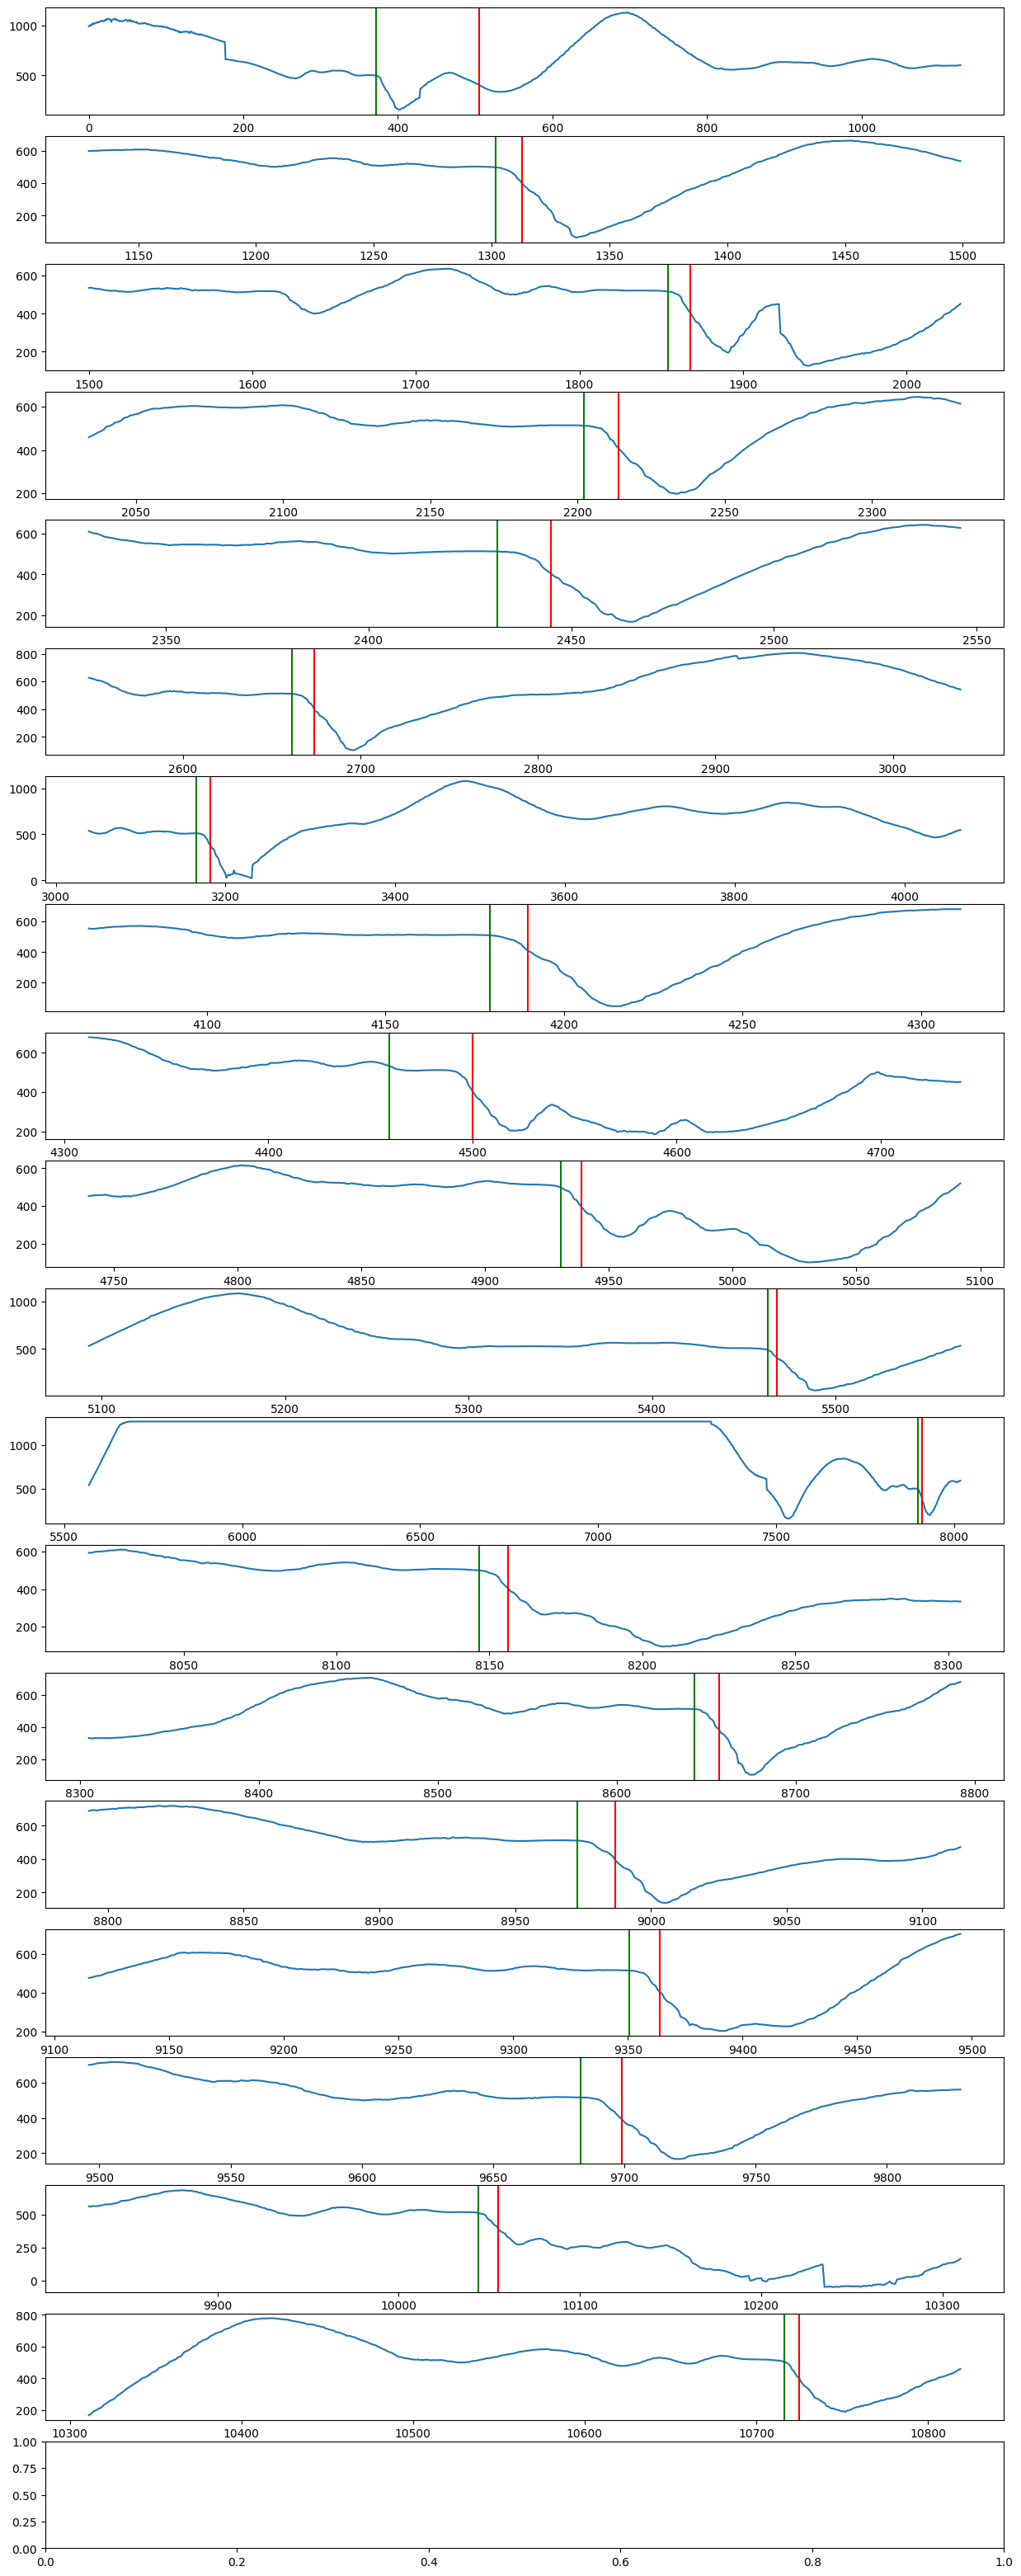

In [15]:
startpts = []
fig, axs = plt.subplots(len(results_time_by_frame), figsize=(15,40), sharex=False)
for index in range(1, len(results_time_by_frame)):
    start = int(results_time_by_frame[index - 1])
    end = int(results_time_by_frame[index])
    hit = minpts[index-1][0]
    if is_epee or is_foil:
        start_pt = check_for_all_start_FE(left_dist, right_dist, vel_left, vel_right, start, hit)
    else:
        start_pt = check_for_all_start(left_dist, right_dist, vel_left, vel_right, start, end)
    startpts.append(start_pt)

    frames = [i for i in range(start, end)]
    axs[index - 1].plot(frames, dist_bw_fencers[start:end])
    axs[index - 1].axvline(x = start_pt, color = 'r')
    axs[index - 1].axvline(x = gt_start[index - 1] * 30, color = 'g')

In [16]:
gt_start

[12.387599999999999,
 43.394562,
 61.81112699999999,
 73.400526,
 81.060858,
 88.72019099999999,
 105.505389,
 139.308552,
 148.63421699999998,
 164.35348199999999,
 182.103714,
 263.298438,
 271.557171,
 288.10960200000005,
 299.099601,
 311.688,
 322.7788979999999,
 334.800864,
 357.214428]

In [17]:
start_timings = [i / 30 for i in startpts]

In [18]:
data_pts = len(start_timings) - len(gt_start)
mse = mean_squared_error(start_timings, gt_start)
rmse = mean_squared_error(start_timings, gt_start, squared=False)
print("Difference in data points:", data_pts)
print("MSE: ", mse)
print("RMSE: ", rmse)

Difference in data points: 0
MSE:  1.2837272407819875
RMSE:  1.1330168757710486


## Getting all possible start points

In [19]:
def both_fencers_engarde_FE(dist_bw_fencers, left_vel, right_vel):
    return (dist_bw_fencers > 340) and (dist_bw_fencers < 460) and fencer_stationary(left_vel) and fencer_stationary(right_vel)

startpts = []
fencers_engarded = False
engarde_count = 0
last_found = 0
for index in range(len(vel_left)):
    left_d = left_dist[index]
    right_d = right_dist[index]
    left_vel = vel_left[index]
    right_vel = vel_right[index]
    if not fencers_engarded:
        if both_fencers_engarde(left_d, right_d, left_vel, right_vel):
            engarde_count += 1
            last_found = index
        elif (index - last_found > 15):
            engarde_count = 0
        if engarde_count == 10:
            fencers_engarded = True
    else:
        ## Fencers have engarded already, check if they move out towards one another
        if not both_fencers_engarde(left_d, right_d, left_vel, right_vel) and left_vel > 0 and right_vel < 0 and dist_bw_fencers[index] < 430:
            startpts.append(index)
            fencers_engarded = False
            engarde_count = 0 

In [21]:
all_start = ground_truth[ground_truth['Bout Start & End'] == 'Action']['Position'].tolist()
all_start = [i / 1000 for i in all_start]
all_start_frames = [int(i * 30) for i in all_start]

Text(0.5, 1.0, 'Right Velocity')

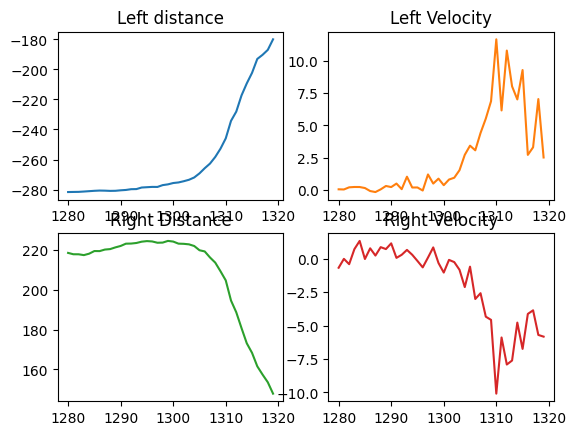

In [24]:
start = 1280
end = 1320
frames = [i for i in range(start, end)]
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(frames, left_dist[start:end])
axs[0, 0].set_title('Left distance')
axs[0, 1].plot(frames, vel_left[start:end], 'tab:orange')
axs[0, 1].set_title('Left Velocity')
axs[1, 0].plot(frames, right_dist[start:end], 'tab:green')
axs[1, 0].set_title('Right Distance')
axs[1, 1].plot(frames, vel_right[start:end], 'tab:red')
axs[1, 1].set_title('Right Velocity')